# Code for fine tuning Code T5 - base on a dataset of 40k+ records.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers pandas

In [ ]:
# Importing necessary libraries
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from transformers import AutoModelForCausalLM, AutoTokenizer, RobertaTokenizer, T5ForConditionalGeneration
import pandas as pd
import json
from sklearn.model_selection import train_test_split

In [ ]:
# Loading the pre-trained model Code T5 - base from Salesforce

from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Salesforce/codet5-base"

tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
# Checking if a CUDA-enabled GPU is available, if not, using the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Moving the model to the specified device (CUDA GPU or CPU)
model.to(device)

# We can see the architecture of Code T5 - base in the output

T5ForConditionalGeneration(
  (shared): Embedding(32100, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
import json
import re
from sklearn.model_selection import train_test_split

def remove_docstrings(code):
    docstring_pattern = r'\'\'\'[\s\S]*?\'\'\'|"""[\s\S]*?"""'
    return re.sub(docstring_pattern, '', code)

def load_and_clean_jsonl(file_name):
    """This function loads and cleans a JSON Lines (JSONL) file,
    extracting 'text' and 'code' fields from each line's JSON object."""

    data = []
    with open(file_name, 'r') as file:
        for line in file:
            json_object = json.loads(line)
            data.append({'text': json_object['text'], 'code': json_object['code']})
    return data

def split_data(data, test_size=0.2, val_size=0.1):
    """Function to split the data into train, validation, and test"""

    train_data, test_data = train_test_split(data, test_size=test_size + val_size)
    val_size_adjusted = val_size / (test_size + val_size)
    val_data, test_data = train_test_split(test_data, test_size=val_size_adjusted)
    return train_data, test_data, val_data

# Load and clean the data
data = load_and_clean_jsonl('drive/MyDrive/combined_file40kplus_withoutcodesearch.jsonl')

# Split the data
train_data, test_data, val_data = split_data(data)



In [ ]:
len(train_data)

32608

In [ ]:
len(test_data)

4659

In [ ]:
len(val_data)

9317

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch


# Defining a custom dataset class for text and code pairs
class TextCodeDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        """Initializing the dataset with input data, tokenizer, and max length"""

        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """Returning the length of the dataset"""

        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        # Tokenize and pad text and code
        text_encodings = self.tokenizer(item['text'], padding='max_length', max_length=self.max_length, truncation=True, return_tensors='pt')
        code_encodings = self.tokenizer(item['code'], padding='max_length', max_length=self.max_length, truncation=True, return_tensors='pt')
        return text_encodings['input_ids'].squeeze(), code_encodings['input_ids'].squeeze()


# Create dataset instances
train_dataset = TextCodeDataset(train_data, tokenizer)
test_dataset = TextCodeDataset(test_data, tokenizer)
val_dataset = TextCodeDataset(val_data, tokenizer)

# Create DataLoader instances
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
from torch.optim import Adam

# We started with learning rate of 3x10^-3 and ended up setting it to 5x10^-5 which was conservative enough to finetune the model
optimizer = Adam(model.parameters(), lr=5e-5)

In [ ]:
from torch.cuda.amp import GradScaler, autocast

# Initialize the gradient scaler for mixed precision
scaler = GradScaler()

# Training and Validation loop
for epoch in range(4):  # Set to 4 because of GPU constraints
    # Training Phase
    model.train()
    total_train_loss = 0

    # Iterating through batches in the training loader
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, labels = [b.to(device) for b in batch]

        # Applying mixed precision training with autocast
        with autocast():
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

        # Scaling gradients, backpropagation, and updating the model parameters
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation Phase
    model.eval()
    total_val_loss = 0
    # Performing validation without calculating gradients
    with torch.no_grad():
        for batch in val_loader:
            input_ids, labels = [b.to(device) for b in batch]

            # Applying mixed precision for validation
            with autocast():
                outputs = model(input_ids=input_ids, labels=labels)
                loss = outputs.loss

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch: {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


Epoch: 0, Training Loss: 0.7172820611497692, Validation Loss: 0.5490670366348627
Epoch: 1, Training Loss: 0.5654641653578345, Validation Loss: 0.5271185534066908
Epoch: 2, Training Loss: 0.5089040958268661, Validation Loss: 0.507729138593817
Epoch: 3, Training Loss: 0.4670853035577497, Validation Loss: 0.503465471483863


In [ ]:
# For PyTorch
model_save_path = 'drive/MyDrive/firsttrain.pth'
import torch
torch.save(model.state_dict(), model_save_path)

In [ ]:
from torch.cuda.amp import GradScaler, autocast

# Initialize the gradient scaler for mixed precision
scaler = GradScaler()

# Training and Validation loop
for epoch in range(2):  # Adjust the number of epochs as needed
    # Training Phase
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, labels = [b.to(device) for b in batch]

        # Mixed precision training
        with autocast():
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation Phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():  # No gradients needed for validation
        for batch in val_loader:
            input_ids, labels = [b.to(device) for b in batch]

            # No need to scale gradients for validation
            with autocast():
                outputs = model(input_ids=input_ids, labels=labels)
                loss = outputs.loss

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch: {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


Epoch: 0, Training Loss: 0.43196179233564536, Validation Loss: 0.5024917476103029
Epoch: 1, Training Loss: 0.4019269341606577, Validation Loss: 0.5050793092266173


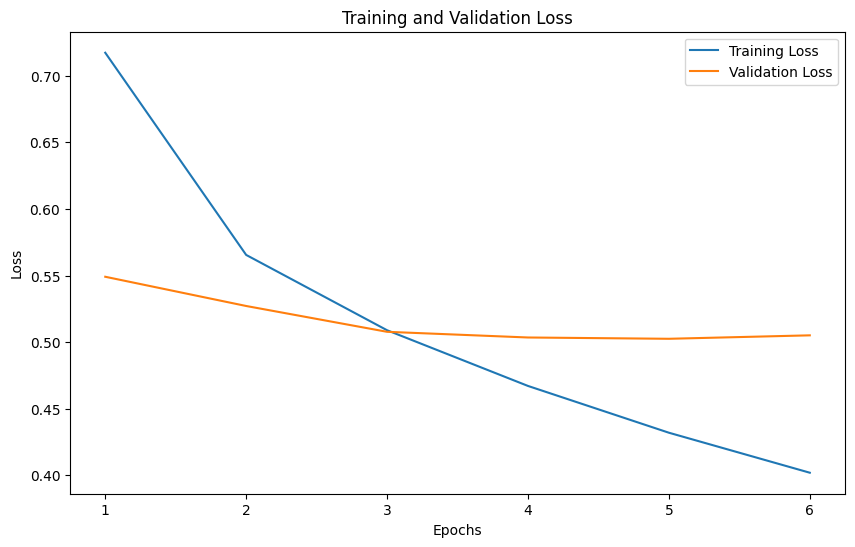

In [ ]:
# Creating a graph of training and validation loss

training_losses = [0.7172820611497692, 0.5654641653578345, 0.5089040958268661, 0.4670853035577497, 0.43196179233564536, 0.4019269341606577]  # Replace with your actual training loss values
validation_losses = [0.5490670366348627, 0.5271185534066908, 0.507729138593817, 0.503465471483863, 0.5024917476103029, 0.5050793092266173]  # Replace with your actual validation loss values
epochs = range(1, len(training_losses) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')

plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# For PyTorch
model_save_path = 'drive/MyDrive/secondtrain.pth'
import torch
torch.save(model.state_dict(), model_save_path)

In [ ]:
# model_save_path = 'drive/MyDrive/secondtrain.pth'

# # Load the saved model state into the model instance
# model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

In [ ]:
def generate_code(model, tokenizer, input_ids, max_length=256):
    """Function to generate code from given inout text"""
    model.eval()
    with torch.no_grad():
        # Generate output sequences
        outputs = model.generate(input_ids=input_ids, max_length=max_length)
    return outputs

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import torch

# Function to evaluate the model and display examples
def evaluate_and_display_examples(model, tokenizer, test_loader, num_examples=3):
    # Set the model to evaluation mode
    model.eval()

    total_bleu_score = 0

    # Turn off gradient computation during evaluation
    with torch.no_grad():
        for batch in test_loader:
            input_ids, labels = [b.to(device) for b in batch]

            # Generate code using the model
            generated_ids = generate_code(model, tokenizer, input_ids)

            # Convert generated and label IDs to text
            generated_texts = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            label_texts = [tokenizer.decode(l, skip_special_tokens=True, clean_up_tokenization_spaces=True) for l in labels]

            # Calculate BLEU score and display examples
            for gen_text, label_text in zip(generated_texts, label_texts):
                bleu_score = sentence_bleu([label_text.split()], gen_text.split())
                total_bleu_score += bleu_score

    avg_bleu_score = total_bleu_score / len(test_loader.dataset)
    print(f"Average BLEU Score on Test Data: {avg_bleu_score}")

# Evaluate the model and display examples
evaluate_and_display_examples(model, tokenizer, test_loader)


Average BLEU Score on Test Data: 0.3572706444942178


In [ ]:
text = "Create a function that checks if a string is a palindrome."
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

# Generating a single sequence
generated_ids = model.generate(input_ids, max_length=128)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))


def isPalindrome ( s ) : 
 	 n = len ( s ) 
 for i in range ( n ) : 
 	 if ( s [ i ]!= s [ n - i - 1 ] ) : 
 	 return False 
 return True 
 def checkPalindrome ( s ) : 
 	 n = len ( s ) 
 if ( checkPalindrome ( s ) ) : 
 	 print ( " Yes " ) 
 else : 
 	 print ( " No " ) 
 


In [ ]:
def isPalindrome(s):
  n = len(s)
  for i in range(n):
      if (s[i]!= s[n - i - 1]) :
        return False
  return True
def checkPalindrome(s):
  # n = len(s)
  if (isPalindrome(s)):
    print( " Yes " )
  else:
    print( " No " )
checkPalindrome("MOM")


 Yes 


In [ ]:
text = "program to add two numbers"
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

# Generating a single sequence
generated_ids = model.generate(input_ids, max_length=128)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))


def add ( x, y ) : 
 	 if x == 0 or y == 0 : 
 	 return x 
 return x + y 
 x = 10 
 y = 10 
 print add ( x, y ) 



In [ ]:
def add ( x, y ) :
  if x == 0 or y == 0 :
    return x
  return x + y
x = 10
y = 10
print(add(x, y))

20


In [ ]:
text = "print hello world"
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

# Generating a single sequence
generated_ids = model.generate(input_ids, max_length=128)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))


def print_hello_world():
     print hello world print hello world 
 def print_hello_world():
     print hello world print hello world 
 def print_hello_world_world():
     print hello world
     print hello world
    print hello world
    print hello world_world_world()
    print hello world_world_world()
    print hello world_world_world()



In [ ]:
text = "program to convert string into upper case"
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

# Generating a single sequence
generated_ids = model.generate(input_ids, max_length=128)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))


def upper(s): 
 	 return s.upper() if s else s.lower() 
 s = " geeksforgeeks " 
 print ( upper ( s ) ) 



In [ ]:
text = "program to convert string into lower case"
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

# Generating a single sequence
generated_ids = model.generate(input_ids, max_length=128)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))


def to_lower_case(string): string = string.lower() if string else string.upper()
 return string.lower()



## After training our pre-trained Code T5 - base model on more than 40k+ records, we achieved a Sentence BLEU score of 35.7% which is a significant improvement over the last model fine tuning with 4k and 10k records.